# The Paired *t*-test
To begin our journey into the world of models for repeated measurements, we will start with the simplest possible example: the paired $t$-test. Last semester, we saw how the humble $t$-test can be subsumed into the linear model framework through the use of *dummy variables*. This same approach can be used with paired data[^paired-foot] because the difference between the *independent* and *paired* $t$-test does not lie with the *mean function*. We spent a lot of time last semester discussing different mean functions and, you will be glad to know, this all follows-over into the world of repeated measurements. The difference lies with the *variance function*. Specifically, how we can alter the variance function to accommodate non-zero correlation between the repeats? As we will see in this part of the lesson, there are *two* equivalent ways of doing this with paired data. One of them *side-steps* the issues of dependence whereas the other does not. However, it is useful to understand how both of these work because it provides some crucial insight into modelling repeated measurements that we will generalise as our models get more complex.     

## Two-sample vs Paired *t*-tests
To begin with, it is useful to examine *how* the results differ between a *two-sample* and *paired* $t$-test. We can don this in `R` by comparing the results of the `t.test()` function with `paired=FALSE` and `paired=TRUE`. To do this, we use the `mice2` data set from the `datarium` package, that contains the weight of a sample of 10 mice both *before* and *after* some treatment. The experimental question concerns whether the treatment affects the weight of the mice. The data is shown below

In [1]:
library('datarium')
data('mice2')
print(mice2)

   id before after
1   1  187.2 429.5
2   2  194.2 404.4
3   3  231.7 405.6
4   4  200.5 397.2
5   5  201.7 377.9
6   6  235.0 445.8
7   7  208.7 408.4
8   8  172.4 337.0
9   9  184.6 414.3
10 10  189.6 380.3


We can compare the output from a *two-sample* $t$-test and a *paired* $t$-test by changing the `paired=` argument of `t.test()`, as shown below

In [2]:
print(t.test(mice2$before, mice2$after, var.equal=TRUE, paired=TRUE))  # paired t-test
print(t.test(mice2$before, mice2$after, var.equal=TRUE, paired=FALSE)) # two-sample t-test


	Paired t-test

data:  mice2$before and mice2$after
t = -25.546, df = 9, p-value = 1.039e-09
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -217.1442 -181.8158
sample estimates:
mean difference 
        -199.48 


	Two Sample t-test

data:  mice2$before and mice2$after
t = -17.453, df = 18, p-value = 9.974e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -223.4926 -175.4674
sample estimates:
mean of x mean of y 
   200.56    400.04 



The output is a bit different between the two methods, so let us spend a little time unpacking what *is* and what *is not* different here. To begin with, the clearest differences between the two methods concern the $t$-statistic itself, the degrees of freedom, the $p$-value and the confidence interval. This is summarised in the table below 

| Test       | *t*-statistic | DoF | *p*-value | 95% CI            | 
| ---------- | ------------- | --- | --------- | ----------------- |
| Paired     | -25.546       | 9   | 1.039e-09 | [-217.14 -181.82] |
| Two-sample | -17.453       | 18  | 9.974e-13 | [-223.49 -175.47] |

Although this may therefore seem like *everything* is different, there is actually one element that is *identical* here, though it is somewhat hidden. To see it, consider that the structure of a $t$-test is

$$
t = \frac{\mu_{1} - \mu_{2}}{\text{SE}\{\mu_{1} - \mu_{2}\}},
$$

meaning that we think of the $t$ as the ratio between the *mean difference* and the *standard error of the mean difference*. The $t$-statistic is different between the *two-sample* and the *paired* tests, but this does not necessarily mean that all elements of this ratio are also different. Indeed, if we look at the output above we can see that the *paired* test reports a mean difference of `-199.48` and the *two-sample* test reports the individual means as `200.56` and `400.04`. If we calculate the mean difference in the *two-sample* test we get 

In [3]:
print(200.56 - 400.04)

[1] -199.48


So, this is *identical* between the *paired* and *two-sample* tests. This should not be surprising, as we already established that repeated measurements do not affect the mean function. So, in either case, the groups means are the same, the mean difference is the same and the *numerator* of the $t$-statistic is the same. From this, we can conclude that the *difference* between the two methods concerns the *denominator* of the $t$-statistic. In other words, *the standard error of the difference changes under repeated measurements*.

Given that we know the numerator for both tests, we can recover the denominators to see that this is the case

In [4]:
mean.diff  <- -199.48
paired.t   <- -25.546
twosamp.t  <- -17.453
paired.se  <-  mean.diff / paired.t
twosamp.se <-  mean.diff / twosamp.t

print(c(paired.se, twosamp.se))

[1]  7.808659 11.429554


So, the *standard error* of the difference is much *smaller* in the *paired* test when compared to the *two-sample* test. This should not be a surprise. Thinking back to our discussion from the beginning of the lesson, we know that the variance of the difference between two random variables should get *smaller* when they are positively correlated. From this, we can conclude that, when applied to *paired* data, the *two-sample* $t$-test is using a standard error that is *too large*. 

This tracks with everything we have discussed so far. However, the key question for us is *how* the *paired* $t$-test is able to do this. As mentioned at the start of this part of the lesson, there are two equivalent ways of thinking about this. We will discuss *both* below because their equivalence provides important information for conceptualising more complex methods. 

## The Model of *Paired Differences*
The first method we can use is actually a bit of a *cheat* in order to side-step the issue of dependence. Effectively, a paired $t$-test can be thought of as a *one-sample* $t$-test on the *difference* between the pairs. We will explore this in more detail below, however, it is useful to know that conceptually this is a really key step because it introduces the idea that we can correctly model repeated measurements by *removing* something from the data. If we can make the paired test correct via subtraction, there must be something that is cancelling-out. Whatever this "something" is, its removal allows us to treat the *differences* between the pairs as independent.

### Paired Differences in `R`
As a first step, we can demonstrate that this idea of subtracting the pairs *does* work, before exploring *why*. We can use the `mice2` data again and create a new variable that represents the difference between `before` the treatment and `after` the treatment.

In [5]:
mice2$treat.diff <- mice2$before - mice2$after
print(mice2)

   id before after treat.diff
1   1  187.2 429.5     -242.3
2   2  194.2 404.4     -210.2
3   3  231.7 405.6     -173.9
4   4  200.5 397.2     -196.7
5   5  201.7 377.9     -176.2
6   6  235.0 445.8     -210.8
7   7  208.7 408.4     -199.7
8   8  172.4 337.0     -164.6
9   9  184.6 414.3     -229.7
10 10  189.6 380.3     -190.7


Now, we can simply perform a one-sample $t$-test on the difference. To do this, we could use the `t.test()` function, but given that our focus is linear models, we will use `lm()` instead.

In [6]:
onesamp.mod <- lm(treat.diff ~ 1, data=mice2)
summary(onesamp.mod)


Call:
lm(formula = treat.diff ~ 1, data = mice2)

Residuals:
   Min     1Q Median     3Q    Max 
-42.82 -11.17   1.28  19.66  34.88 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -199.480      7.809  -25.55 1.04e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.69 on 9 degrees of freedom


The test on the intercept parameter $(\beta_{0})$ is now *identical* to the paired $t$-test from earlier.

### Removing the Effect of the Subjects
Given what we have demonstrated above, the key insight is that taking $y_{i\Delta} = y_{i1} - y_{i2}$ allows us to treat the values of $y_{i\Delta}$ as *independent*[^delta-foot]. Effectively, the element that makes repeated measurements difficult has been *removed* via this subtraction. Given that we know that *correlation* is the issue, taking $y_{i\Delta} = y_{i1} - y_{i2}$ *must* be removing the correlation from the data. This is fairly intuitive because we have reduced correlated pairs of data down to only a single value per-subject. Given that the subjects are taken as independent, the values of $y_{i\Delta}$ must also be independent. In effect, there are *no* repeated measurements anymore. However, expressing this formally is a useful stepping-stone to more general methods.

To see what is happening, let us return to our basic $t$-test model from last semester where we parameterise each group mean in terms of the grand mean plus a group-specific deflection. The mean for the first repeated measurement is therefore $\mu_{1} = \mu + \alpha_{1}$ and the mean for the second repeated measurement is $\mu_{2} = \mu + \alpha_{2}$. 

To capture the concept of *dependence* between these repeats, we split the error into *two* components $\epsilon_{ij} = S_{i} + \eta_{ij}$. This consists of a *shared component* for each subject, called $S_{i}$, as well as a *unique component* for each observation, called $\eta_{ij}$. For the two repeated measurements, the model is therefore

$$
\begin{alignat*}{1}
    y_{i1} &= \mu + \alpha_{1} + \overbrace{S_{i} + \eta_{i1}}^{\epsilon_{ij}} \\
    y_{i2} &= \mu + \alpha_{2} + S_{i} + \eta_{i2} 
\end{alignat*}.
$$

So, the reason why $y_{i1}$ and $y_{i2}$ are correlated is because they *share* the same component $S_{i}$. This captures the idea that these measurements come from the *same subject*. If we then *subtract* $y_{i1}$ and $y_{i2}$, the term $S_{i}$ will cancel-out[^intercept-foot]

$$
\begin{alignat*}{1}
    y_{i\Delta} = y_{i1} - y_{i2} &= (\mu + \alpha_{1} + S_{i} + \eta_{i1}) - (\mu + \alpha_{2} + S_{i} + \eta_{i2}) \\
                                  &= (\alpha_{1} - \alpha_{2}) + (\eta_{i1} - \eta_{i2}) \\
                                  &= \alpha_{\Delta} + \eta_{i\Delta}
\end{alignat*}.
$$

So, this tells us that $S_{i}$ precisely captures the *correlation*, because removing it renders the data *independent*. 

### Visualising the Model

We can also visualise what is happening here, to gain further intuition. The plot below shows each mouse along the $x$-axis, with their weight along the $y$-axis. The two treatments are shown for each mouse as two different coloured points and the grand mean is shown as a solid black line

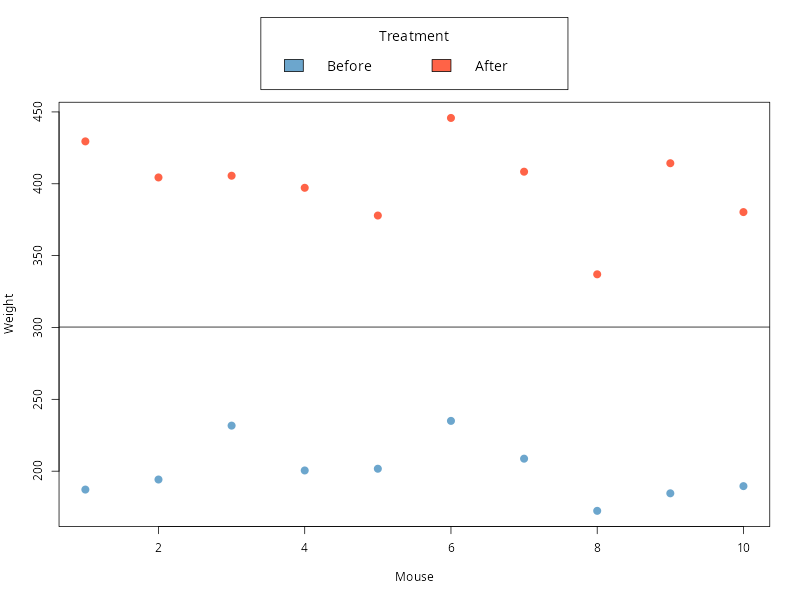

In [8]:
library(reshape2)
data('mice2')

mice2.long <- melt(mice2, 
                   id.vars       = "id", 
                   variable.name = "treatment", 
                   value.name    = "weight")
p <- par()
par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(mice2.long$id,
     mice2.long$weight,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5)

abline(h=mean(mice2.long$weight), xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

According to the model

$$
y_{ij} = \mu + \alpha_{j} + S_{i} + \eta_{ij}
$$

there are *three* sources of variance that explain why the data deflects from the grand mean. The first is variation associated with the two treatments (the $\alpha_{j}$ terms), the second is variation associated with the different subjects (the $S_{i}$ terms) and the third is random error unrelated to anything else (the $\eta_{ij}$ terms). 

In order to understand this in more detail, and how it relates to repeated measurements, we can *remove* each source of variance from the data and then see what the plot looks like. Starting with the two treatments, if we remove the treatment effects from the data (the $\alpha_{j}$) we get the following 

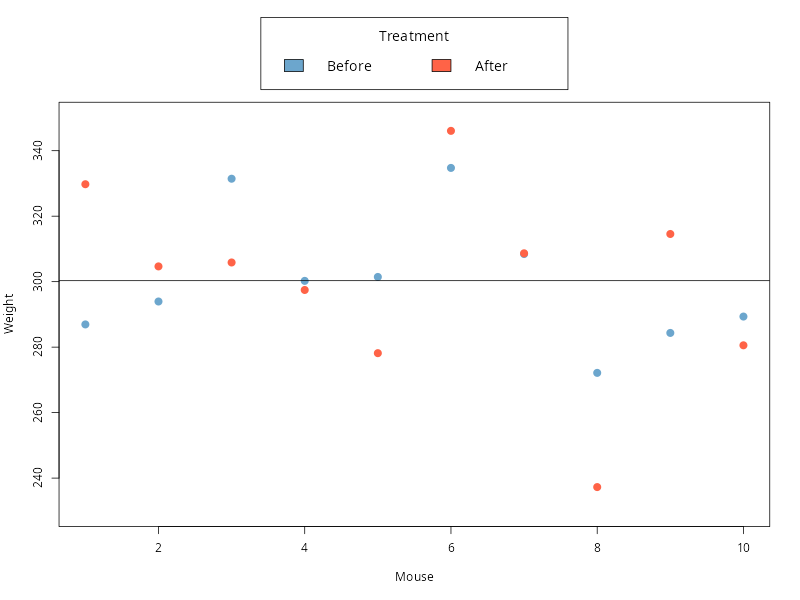

In [41]:
mod           <- lm(weight ~ treatment, data=mice2.long, contrasts=list(treatment=contr.sum))
res.twosample <- resid(mod)
res.twosample <- res.twosample + coef(mod)[1]

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(as.numeric(mice2.long$id),
     res.twosample,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5, 
     ylim=c(230,350))

abline(h=coef(mod)[1], xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

Now, after removing the *predictable* element of the variance, we should be left with only the *unpredictable* element. In other words, the plot above shows all the reasons, *other* than the two experimental conditions, why the data do not adhere to the grand mean. Going back to our model, this shows

$$
y_{ij} - \alpha_{j} = \mu + S_{i} + \eta_{ij}.
$$

So, there are two sources to this error. One relates to the fact that the data come from different subjects and the other is just random noise. Rather than a *single* vertical distance from the grand mean ($\epsilon_{ij}$) we have split this distance into *two* parts: the distance associated with the subject ($S_{i}$) and then anything left over ($\eta_{ij}$). Of interest is that the *correlation* induced by the repeated measurements can be seen above. Notice how the data from each subject is closely linked. For instance, both measurements for mouse 6 are close together and are both *above* the grand mean. Similarly, both measurements for mouse 8 are close together and are both *below* the grand mean. This implies that each mouse has a unique *constant offset* that moves their measurements above or below the grand mean *as a pair*. The fact that this offset moves the measurements *together* explains why the repeated measurements are *correlated*. In principle, if we remove this offset we remove the correlation. 

So, let us see what happens if we remove the constant offset given by $S_{i}$. This gives

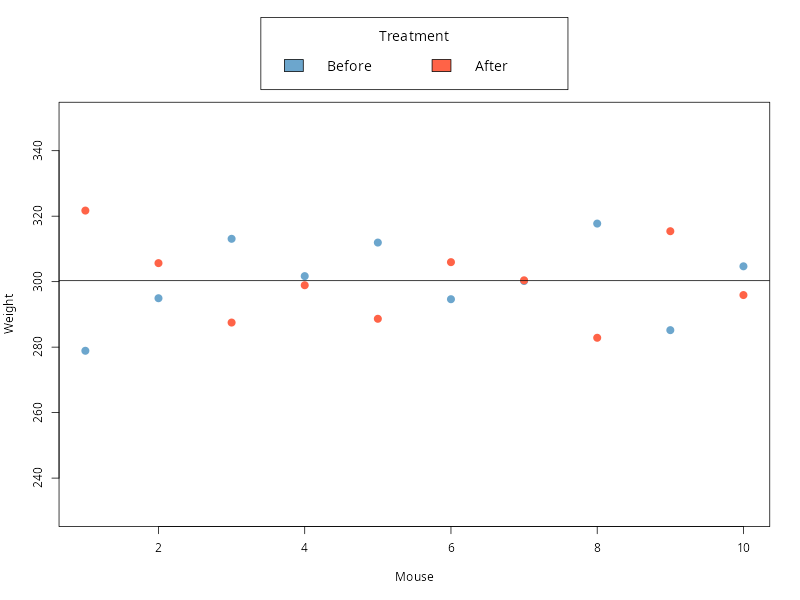

In [40]:
mice2.long$id <- as.factor(mice2.long$id)
mod           <- lm(weight ~ treatment + id, data=mice2.long, contrasts=list(treatment=contr.sum,id=contr.sum))
res.nosub     <- resid(mod) + coef(mod)[1]

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(as.numeric(mice2.long$id),
     res.nosub,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5, 
     ylim=c(230,350))

abline(h=coef(mod)[1], xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

Now we can see that the constant offset that moves each subject in different directions from the grand mean has been removed. Each subject is now *on an equal footing*. Mouse 6 is no longer far above the grand mean, nor is Mouse 8 far below the grand mean. Going back to our model, this shows

$$
y_{ij} - \alpha_{j} - S_{i} = \mu + \eta_{ij}.
$$

We have therefore removed the element that causes the data to be correlated and the only variation left is the random error term $\eta_{ij}$. Subtracting the $S_{i}$ effectively *removes* the value that shifts each subject's measurements *away* from the mean by some amount that is *unique* to each subject, but *constant* across their own measurements. We can think of this like each person having their own "bias" that makes them behave *more* or *less* like the population average. This "bias" is what makes that person's repeats correlated, because this is what makes the measurements similar to each other (i.e. both measurements *larger* than average or *smaller* than average). If we *remove* this "bias", we *remove* the correlation and the only variance that remains is unrelated to each subject. In the paired $t$-test, this is removed *implicitly* by the subtraction of the pairs.

`````{admonition} A Poetic Explanation
:class: tip
In their book "Analysis of Repeated Measures", Crowder and Hand (1990) refer to the elements of the model

$$
y_{ij} = \mu + \alpha_{j} + S_{i} + \eta_{ij}
$$

in a more poetic way that may help get a sense of what the model terms are capturing. They refer to $\mu_{j} = \mu + \alpha_{j}$ as an "immutable constant of the universe", $S_{i}$ as a "lasting characteristic of the individual" and $\eta_{ij}$ as a "fleeting aberration of the moment". So, $\mu_{j} = \mu + \alpha_{j}$ represents something fundamental and universal about the effect of the different treatments that is true across all measurements of those treatments. $S_{i}$ captures something that is specific and unique to subject $i$ that is true across all their repeated measurements, and $\eta_{ij}$ represents random noise that occurred at the point of measurement that is unrelated to the experimental condition or the individual.
``````

## Inference in the Model of *Paired Differences*
At the beginning of this part of the lesson, we indicated that a key difference between a *paired* $t$-test and a *two-sample* $t$-test was the standard error used for the test statistic. We will now see how this aligns with the model of *paired differences* and the idea of *removing* the variance associated with the $S_{i}$ terms.

Earlier, we introduced the terms $S_{i}$ and $\eta_{ij}$ by *splitting* the usual single error term in two

$$
\epsilon_{ij} = S_{i} + \eta_{ij}.
$$

Remembering that the errors are used to capture the *variance* of $y_{ij}$, this split also corresponds to a *partition of the variance*

$$
\sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}.
$$

... So now we have *two* variance terms, one associated with the differences between the subjects and one associated with measurements within each subject. $\sigma^{2}_{b}$ captures variation due to the fact that we have measured different subjects and $\sigma^{2}_{w}$ captures everything else. We can therefore specify this model more generally as

$$
y_{ij} \sim\mathcal{N}(\mu + \alpha_{j}, \sigma^{2}_{b} + \sigma^{2}_{w})
$$

We will discuss this model specification in more detail in the next part of this lesson, as it is a key result that leads us both to the repeated measures ANOVA and the mixed-effects models that are the focus of this part of the unit. For now, let us see what happens to the variance if we take the *difference* $y_{i\Delta} = y_{i1} - y_{i2}$.

...

For reasons we will give in the next part of the lesson, the covariance between the repeated measurements is

$$
\text{Cov}(y_{i1},y_{i2}) = \sigma^{2}_{b}.
$$

Because of this, the variance of the difference becomes ...

So, the between-subjects variance *disappears* and the only variance left-over is the within-subject variance. This is exactly the same result as the term $S_{i}$ disappearing in the subtraction, but just expressed in terms of variance.

Taking all this together, the reason that the standard error is *smaller* in the paired $t$-test is because it is derived from the *within-subject* variance. Not only is this a *partition* of the overall variance, but it is generally the *smaller* partition of the two.


[^foot2]: Here we set the variance to be the same between the samples because this (a) agrees with the simulations and (b) prevents conflation of the issue of correlation with conflation of the issue of homogeneity of variance.

[^foot1]: Due to the way the factors are coded in `R`, the coefficient is actually the opposite comparison here, hence why the $t$-statistic is *positive* rather than *negative*.

[^intercept-foot]: So too will the intercept term $\mu$, but this just means that the data will be *mean centred* with 0 representing no difference between the repeated measurements.

[^delta-foot]: The Greek letter $\Delta$ (capital *delta*) is often used as a shorthand for *change* or *difference*. So, $y_{i\Delta}$ reflects the *difference* between the two repeated measurements for subject $i$.